In [1]:
%load_ext autoreload
%autoreload 2

# Bike number of spots prediction EDA

**Objective**: Predict the minimum number of spots available by station, hour and date from April to November.

This notebook's purpose is to conduct a Exploratory Data Analysis (EDA) for both historical bixi rides and weather data. Some of the questions we are looking for are the following:

- Loadining data and cleaning data
    - Standarize stations names
- How many bixi stations exist ?
- What are the number of average rides per day of the week, month and hour of the day ?
- Explore the most popular stations and rides
- What are the number of average available spots day of the week, month and hour of the day ?
- Explore weather data
- How does the number of rides correlate with weather (i.e precipiation, temperature, sunnny days) ?

**For simplicity, we'll perform the subsequent analysis using data obatined by running the developed** `RidesDataPipeline` **for years 2023 to 2024**

In [12]:
# declaring dependencies
from pandas import Series, merge, read_csv, to_datetime, Grouper, date_range, set_option, concat
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import unicodedata
from utils import standarize_station_name
from bixi_availability_prediction.etl import get_stations_capacity
from constants import STATION_CAPACITY_URL
from numpy import nan, where
import os
from functools import reduce

In [2]:
set_option('display.max_rows', 1500)
set_option('display.max_columns', 50)

## Quick exploration of the raw data

In [36]:
df = read_csv('bixi_rides_2024.csv')

In [37]:
df = df.assign(
    STARTTIMEMS=to_datetime(df['STARTTIMEMS'], unit='ms'),
    ENDTIMEMS=to_datetime(df['ENDTIMEMS'], unit='ms')
)

In [5]:
df['TIMEDELTA'] = df['ENDTIMEMS'] - df['STARTTIMEMS']

In [45]:
mask = (df['STARTSTATIONNAME'] == 'du Champ-de-Mars / Gosford') | (df['ENDSTATIONNAME'] == 'du Champ-de-Mars / Gosford')
df_delacommune = df[mask]

In [52]:
df.head()

,STARTSTATIONNAME,STARTSTATIONARRONDISSEMENT,STARTSTATIONLATITUDE,STARTSTATIONLONGITUDE,ENDSTATIONNAME,ENDSTATIONARRONDISSEMENT,ENDSTATIONLATITUDE,ENDSTATIONLONGITUDE,STARTTIMEMS,ENDTIMEMS
0,Métro Champ-de-Mars (Viger / Sanguinet),Ville-Marie,45.510253,-73.556777,St-Antoine / Jean-Paul Riopelle,Ville-Marie,45.502940,-73.560640,2024-01-02 21:25:56.167,2024-01-02 21:31:46.232
1,Métro Place-d'Armes (Viger / St-Urbain),Ville-Marie,45.506314,-73.559671,de Maisonneuve / Aylmer (est),Ville-Marie,45.505386,-73.570432,2024-01-02 22:01:28.826,2024-01-02 22:08:23.502
2,Émile-Duployé / Sherbrooke,Le Plateau-Mont-Royal,45.527195,-73.564526,Parc Molson (d'Iberville / Beaubien),Rosemont - La Petite-Patrie,45.549022,-73.591982,2024-01-02 23:29:14.678,2024-01-02 23:49:19.500
3,Marmier / St-Denis,Rosemont - La Petite-Patrie,45.531027,-73.598623,Roy / St-André,Le Plateau-Mont-Royal,45.521564,-73.570367,2024-01-02 21:58:15.740,2024-01-02 22:08:49.014
4,Marmier / St-Denis,Rosemont - La Petite-Patrie,45.531027,-73.598623,Parc Molson (d'Iberville / Beaubien),Rosemont - La Petite-Patrie,45.549022,-73.591982,2024-01-03 01:03:16.167,2024-01-03 01:14:44.511


In [47]:
df_delacommune['RIDE'] = 1

/tmp/ipykernel_332506/1875718194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delacommune['RIDE'] = 1


In [48]:
departures_grouped = (
    df_delacommune
    .groupby(['STARTSTATIONNAME', Grouper(key='STARTTIMEMS',freq='h')])['RIDE']
    .sum()
    .reset_index()
    .rename(columns={'STARTSTATIONNAME' :'station_name','STARTTIMEMS':'datetime','RIDE':'num_of_departures'})
)

arrivals_grouped = (
    df_delacommune
    .groupby(['ENDSTATIONNAME', Grouper(key='ENDTIMEMS',freq='h')])['RIDE']
    .sum()
    .reset_index()
    .rename(columns={'ENDSTATIONNAME' :'station_name','ENDTIMEMS':'datetime','RIDE':'num_of_arrivals'})
)

In [56]:
dates = date_range(
    start='2024-04-01', 
    end='2024-11-30', 
    freq='H'
).to_frame(index=False, name='datetime')
dates['station_name'] = 'du Champ-de-Mars / Gosford'

/tmp/ipykernel_332506/369337092.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = date_range(


In [57]:
availability_per_station = (
    dates
    .merge(departures_grouped, how='left', on=['datetime','station_name'])
    .merge(arrivals_grouped, how='left', on=['datetime','station_name'])
    .fillna(0)
)

availability_per_station['delta'] = availability_per_station['num_of_arrivals'] - availability_per_station['num_of_departures']
availability_per_station['cum_delta'] = availability_per_station.groupby(['station_name'])['delta'].transform('cumsum')


In [58]:
availability_per_station.head(1500)

,datetime,station_name,num_of_departures,num_of_arrivals,delta,cum_delta
0,2024-04-01 00:00:00,du Champ-de-Mars / Gosford,0.0,4.0,4.0,4.0
1,2024-04-01 01:00:00,du Champ-de-Mars / Gosford,0.0,1.0,1.0,5.0
2,2024-04-01 02:00:00,du Champ-de-Mars / Gosford,0.0,0.0,0.0,5.0
3,2024-04-01 03:00:00,du Champ-de-Mars / Gosford,0.0,0.0,0.0,5.0
4,2024-04-01 04:00:00,du Champ-de-Mars / Gosford,0.0,0.0,0.0,5.0
5,2024-04-01 05:00:00,du Champ-de-Mars / Gosford,0.0,0.0,0.0,5.0
6,2024-04-01 06:00:00,du Champ-de-Mars / Gosford,0.0,0.0,0.0,5.0
7,2024-04-01 07:00:00,du Champ-de-Mars / Gosford,0.0,0.0,0.0,5.0
8,2024-04-01 08:00:00,du Champ-de-Mars / Gosford,0.0,0.0,0.0,5.0
9,2024-04-01 09:00:00,du Champ-de-Mars / Gosford,0.0,0.0,0.0,5.0


## Loadining data and cleaning data

In order to proceed with the subsequent steps, we'll first load the historical rides data and perform some general cleanining steps

In [59]:
hist_rides=read_csv('historical_rides_data_2023_to_2024.csv')

In [60]:
# setting column for ride number
# to facilitate grouping operations
hist_rides['RIDE'] = 1

In [61]:
# enforcing datatime data type
hist_rides = hist_rides.assign(
    start_date=to_datetime(hist_rides['start_date']),
    end_date=to_datetime(hist_rides['end_date'])
)

In [62]:
mask = (hist_rides['name_start_station'] == 'de la Commune / Place Jacques-Cartier') | (hist_rides['name_end_station'] == 'de la Commune / Place Jacques-Cartier') 
hist_rides[mask].sort_values(by='start_date').to_csv('de_la_commune_test.csv')

### Standarize stations names

Station names are not standard overtime. For example, for certain years, non-ASCII are present while is not for others. The same happens with spaces and casining. Therefore, a utility function to standarize the name need to be developed and subsequently applied on rides/statations capacity datasets.

One factor to consider when designing this function is the size of the rides data. There are millions of rows for a single year which could be problematic if we were to apply the standarization for each line even considerining the use of vectorized functions. Hence, our approach will to first indetify the unique station names, apply the standarization, create a dictionary for reference and then apply that dictionary to the original pandas series.

In [63]:
def standarize_station_name(series: Series) -> Series:
    """
    Remove non-ASCII charcaters, lowercase and strip station name
    """
    cleaned_series = series.fillna('bixi_maintenance')
    unique_stations = cleaned_series.unique()
    cleaned_station_names = {
        station: (
            station.encode('ascii', 'ignore')
            .decode('ascii')
            .lower()
            .replace(' ', '')
            .replace('/', '_')
            .strip()
        )
        for station in unique_stations
    }

    return  cleaned_series.map(cleaned_station_names)

In [67]:
# cleaning station names
hist_rides['name_start_station'] = standarize_station_name(hist_rides['name_start_station'])
hist_rides['name_end_station'] = standarize_station_name(hist_rides['name_end_station'])

In [68]:
hist_rides[hist_rides['name_start_station'] == 'de la Commune / Place Jacques-Cartier'].sort_values(by='start_date')

,Unnamed: 0,start_date,end_date,name_start_station,name_end_station,latitude_start_station,longitude_start_station,latitude_end_station,longitude_end_station,RIDE,name_start_station_cleaned,name_end_station_cleaned


## How many bixi stations exist ?

In [ ]:
len(hist_rides['name_start_station'].unique())

After removing the duplicates, we can observe that there are around 1200 unique stations in Montreal

## What are the number of average rides per day of the week, month and hour of the day ?

In [ ]:
hist_rides.head()

In [ ]:
hist_rides.groupby(Grouper(key='start_date', freq='D'))['RIDE'].sum().reset_index()

In [ ]:
# let's first check the overall trend
# plotting number of rides per week
fig, axes = plt.subplots(figsize=(15, 5))

sns.lineplot(
    x='start_date', 
    y='RIDE', 
    data=hist_rides.groupby(Grouper(key='start_date', freq='W'))['RIDE'].sum().reset_index()
)

In [ ]:
# extracting time parameters for aggregations
hist_rides['MONTH'] = hist_rides['start_date'].dt.month
hist_rides['WEEK_DAY'] = hist_rides['start_date'].dt.weekday
hist_rides['START_HOUR'] = hist_rides['start_date'].dt.hour
hist_rides['END_HOUR'] = hist_rides['end_date'].dt.hour
hist_rides['WEEK_OF_YEAR'] = hist_rides['start_date'].dt.isocalendar().week

In [ ]:
# mask for april to november
mask = hist_rides['MONTH'].between(4,11)

In [ ]:
# performing desired aggregations
agg_by_month = hist_rides[mask]['MONTH'].value_counts(normalize=True).reset_index()
agg_by_weekday = hist_rides[mask]['WEEK_DAY'].value_counts(normalize=True).reset_index()
agg_by_start_hour = hist_rides[mask]['START_HOUR'].value_counts(normalize=True).reset_index()
agg_by_end_hour = hist_rides[mask]['END_HOUR'].value_counts(normalize=True).reset_index()

In [ ]:
# plotting aggregations
fig, axes = plt.subplots(2, 2, figsize=(25, 15))

sns.barplot(x='MONTH', y='proportion', data=agg_by_month, ax=axes[0][0])
sns.barplot(x='WEEK_DAY', y='proportion', data=agg_by_weekday, ax=axes[0][1])
sns.barplot(x='START_HOUR', y='proportion', data=agg_by_start_hour, ax=axes[1][0])
sns.barplot(x='END_HOUR', y='proportion', data=agg_by_end_hour, ax=axes[1][1])
sns.barplot(x='END_HOUR', y='proportion', data=agg_by_end_hour, ax=axes[1][1])

axes[0][0].set_title('Proportion of rides per Month')
axes[0][1].set_title('Proportion of rides per Week Day')
axes[1][0].set_title('Proportion of rides per Ride Start Hour')
axes[1][1].set_title('Proportion of rides per Ride End Hour')

Based on the charts above, it's possible to state the following:
* July to September (not susprisingly given the warmer weather) are the months with the highest number of rides which decrease sharply after October,
* Riders tend to perfer to ride the most on Fridays and Saturdays and the least on Mondays.
* The number of rides increases sharply from 9AM to 9PM and decreases substentialy from 10PM to 8AM for both departures and arrivals at stations

## Explore the most popular stations and rides

In [ ]:
# most popular departure stations
agg_by_start_station = hist_rides['name_start_station'].value_counts(normalize=True).reset_index()
agg_by_start_station['CUM_PROPORTIONS'] = agg_by_start_station['proportion'].cumsum()
agg_by_start_station.head(1000)

80% of the departures tend to occur within 500 stations

In [ ]:
# most popular arrival stations neighbordhood
agg_by_end_station = hist_rides['name_end_station'].value_counts(normalize=True).reset_index()
agg_by_end_station['CUM_PROPORTIONS'] = agg_by_end_station['proportion'].cumsum()
agg_by_end_station.head(1000)

The end stations follows the same patterns as the departure ones

In [ ]:
# checking the most popular ride routes
agg_by_route = (
    hist_rides[['name_start_station','name_end_station']]
    .value_counts(normalize=True)
    .reset_index()
)
agg_by_route['CUM_PROPORTIONS'] = agg_by_route['proportion'].cumsum()
agg_by_route['CIRCULAR_RIDE_FLAG'] = agg_by_route.apply(
    lambda row: 1 if row['name_start_station'] == row['name_end_station'] else 0, axis=1
)

In [ ]:
# number of unique rides
agg_by_route.shape[0]

In [ ]:
agg_by_route

In [ ]:
hist_rides['CIRCULAR_RIDE_FLAG'] = hist_rides.apply(
    lambda row: 1 if row['name_start_station'] == row['ENDSTATIONNAME'] else 0, axis=1
)

In [ ]:
# checking for circular rides (start and end stations are the same)
agg_by_circular_routes = (
    hist_rides['CIRCULAR_RIDE_FLAG']
    .value_counts(normalize=True)
    .reset_index()
)

In [ ]:
agg_by_circular_routes

There around 583 k different rides that take place within the 165 bixi stations. Of those, only 4% are cicular (start and end station are the same)

## What are the number of average available spots day of the week, month and hour of the day ?

Our target variable is number of bikes available per station and not number of trips as pervioulsy explored. Thus, it's necessary to calculate our target varibale overtime as there is not historical information on this. The only data availabe is, unfortunately, the live one provided by Bixi through an API.

In [69]:
# importining station capacity and cleaning station name
stations_capacity = get_stations_capacity(STATION_CAPACITY_URL)
stations_capacity['station_name'] = standarize_station_name(stations_capacity['station_name'])

In [109]:
# creating an index containing datetime range (April to November)
# per each one of the stations where we know the capacity
dates = date_range(
    start='2023-04-01', 
    end='2024-11-30', 
    freq='h'
).to_frame(index=False, name='datetime')

# creating the time/station index for
# subsequent calculations
time_station_index = dates.merge(
    stations_capacity,
    how='cross'
)


In [110]:
# creating an index with departures and arrivals to
# enable the availaability calculations per hour
departures_grouped = (
    hist_rides
    .groupby(['name_start_station', Grouper(key='start_date',freq='h')])['RIDE']
    .sum()
    .reset_index()
    .rename(columns={'name_start_station' :'station_name','start_date':'datetime','RIDE':'num_of_departures'})
)

arrivals_grouped = (
    hist_rides
    .groupby(['name_end_station', Grouper(key='end_date',freq='h')])['RIDE']
    .sum()
    .reset_index()
    .rename(columns={'name_end_station' :'station_name','end_date':'datetime','RIDE':'num_of_arrivals'})
)

In [120]:
# merging the datasetes to perform the availability calculations
availability_per_station = (
    time_station_index
    .merge(departures_grouped, how='left', on=['datetime','station_name'])
    .merge(arrivals_grouped, how='left', on=['datetime','station_name'])
    .fillna(0)
)
availability_per_station['year'] = availability_per_station['datetime'].dt.year
availability_per_station['delta'] = availability_per_station['num_of_arrivals'] - availability_per_station['num_of_departures']
availability_per_station['cum_delta'] = availability_per_station.groupby(['station_name','year'])['delta'].transform('cumsum')
availability_per_station['4_hours_avg_delta'] = availability_per_station.groupby(['station_name','year'])['delta'].transform(lambda x: x.rolling(7).mean())

In [121]:
availability_per_station[availability_per_station['station_name'] == 'delacommune_placejacques-cartier'].head(1000)

,datetime,station_name,capacity,num_of_departures,num_of_arrivals,year,delta,cum_delta,4_hours_avg_delta
6,2023-04-01 00:00:00,delacommune_placejacques-cartier,81,0.0,0.0,2023,0.0,0.0,NaN
211,2023-04-01 01:00:00,delacommune_placejacques-cartier,81,0.0,0.0,2023,0.0,0.0,NaN
416,2023-04-01 02:00:00,delacommune_placejacques-cartier,81,0.0,0.0,2023,0.0,0.0,NaN
621,2023-04-01 03:00:00,delacommune_placejacques-cartier,81,0.0,0.0,2023,0.0,0.0,NaN
826,2023-04-01 04:00:00,delacommune_placejacques-cartier,81,0.0,0.0,2023,0.0,0.0,NaN
1031,2023-04-01 05:00:00,delacommune_placejacques-cartier,81,0.0,0.0,2023,0.0,0.0,NaN
1236,2023-04-01 06:00:00,delacommune_placejacques-cartier,81,0.0,0.0,2023,0.0,0.0,0.000000
1441,2023-04-01 07:00:00,delacommune_placejacques-cartier,81,0.0,0.0,2023,0.0,0.0,0.000000
1646,2023-04-01 08:00:00,delacommune_placejacques-cartier,81,0.0,0.0,2023,0.0,0.0,0.000000
1851,2023-04-01 09:00:00,delacommune_placejacques-cartier,81,0.0,0.0,2023,0.0,0.0,0.000000


In [112]:
availability_per_station.groupby(['station_name'])[['cum_delta','capacity']].min().reset_index().sort_values(by='cum_delta', ascending=False)

,station_name,cum_delta,capacity
164,peel_notre-dame,0.0,43
134,mtroplace-d'armes(st-urbain_viger),0.0,19
98,lanouette_del'glise,0.0,15
152,parcdelaconfdration(fielding_westhill),0.0,23
157,parclabelle(lasalle_henri-duhamel),0.0,11
158,parcmacdonald(clanranald_isabella),0.0,15
159,parcmilie-gamelin(st-hubert_demaisonneuvesud),0.0,19
162,parcst-gabriel(grandtrunk_ropery),0.0,19
38,decourcelle_acorn,0.0,21
49,delanaudire_jean-talon,0.0,23


In [113]:
availability_per_station.groupby(['station_name'])[['cum_delta','capacity']].max().reset_index().sort_values(by='cum_delta', ascending=False)

,station_name,cum_delta,capacity
43,delacommune_placejacques-cartier,27933.0,81
139,mtrost-laurent(demaisonneuve_st-laurent),19931.0,24
37,complexedesjardins(st-urbain_ren-lvesque),19380.0,41
164,peel_notre-dame,16143.0,43
178,square-victoria(viger_dusquare-victoria),14977.0,19
44,delacommune_st-sulpice,12535.0,47
130,mtropapineau(dorion_demaisonneuve),12177.0,32
179,squareviger(berri_viger),11522.0,29
41,delacommune_berri,10653.0,71
42,delacommune_king,10384.0,79


Based on the gropping provided above, it is clear that something is "off". In mamany cases, the cumulative delta of arrivals and departures outstrip the total capacity of bikes. After deeply analyzing the raw data in search for potential errors, I believe that the issue relies on some ridden information from bixi. Potentailly, some bike rebalancing operations performed by BIXI are not present on the trips data which would explain the weird number observed.

Let's dig deeper into a station with extreme values; delacommune_placejacques-cartier

<Axes: xlabel='datetime'>

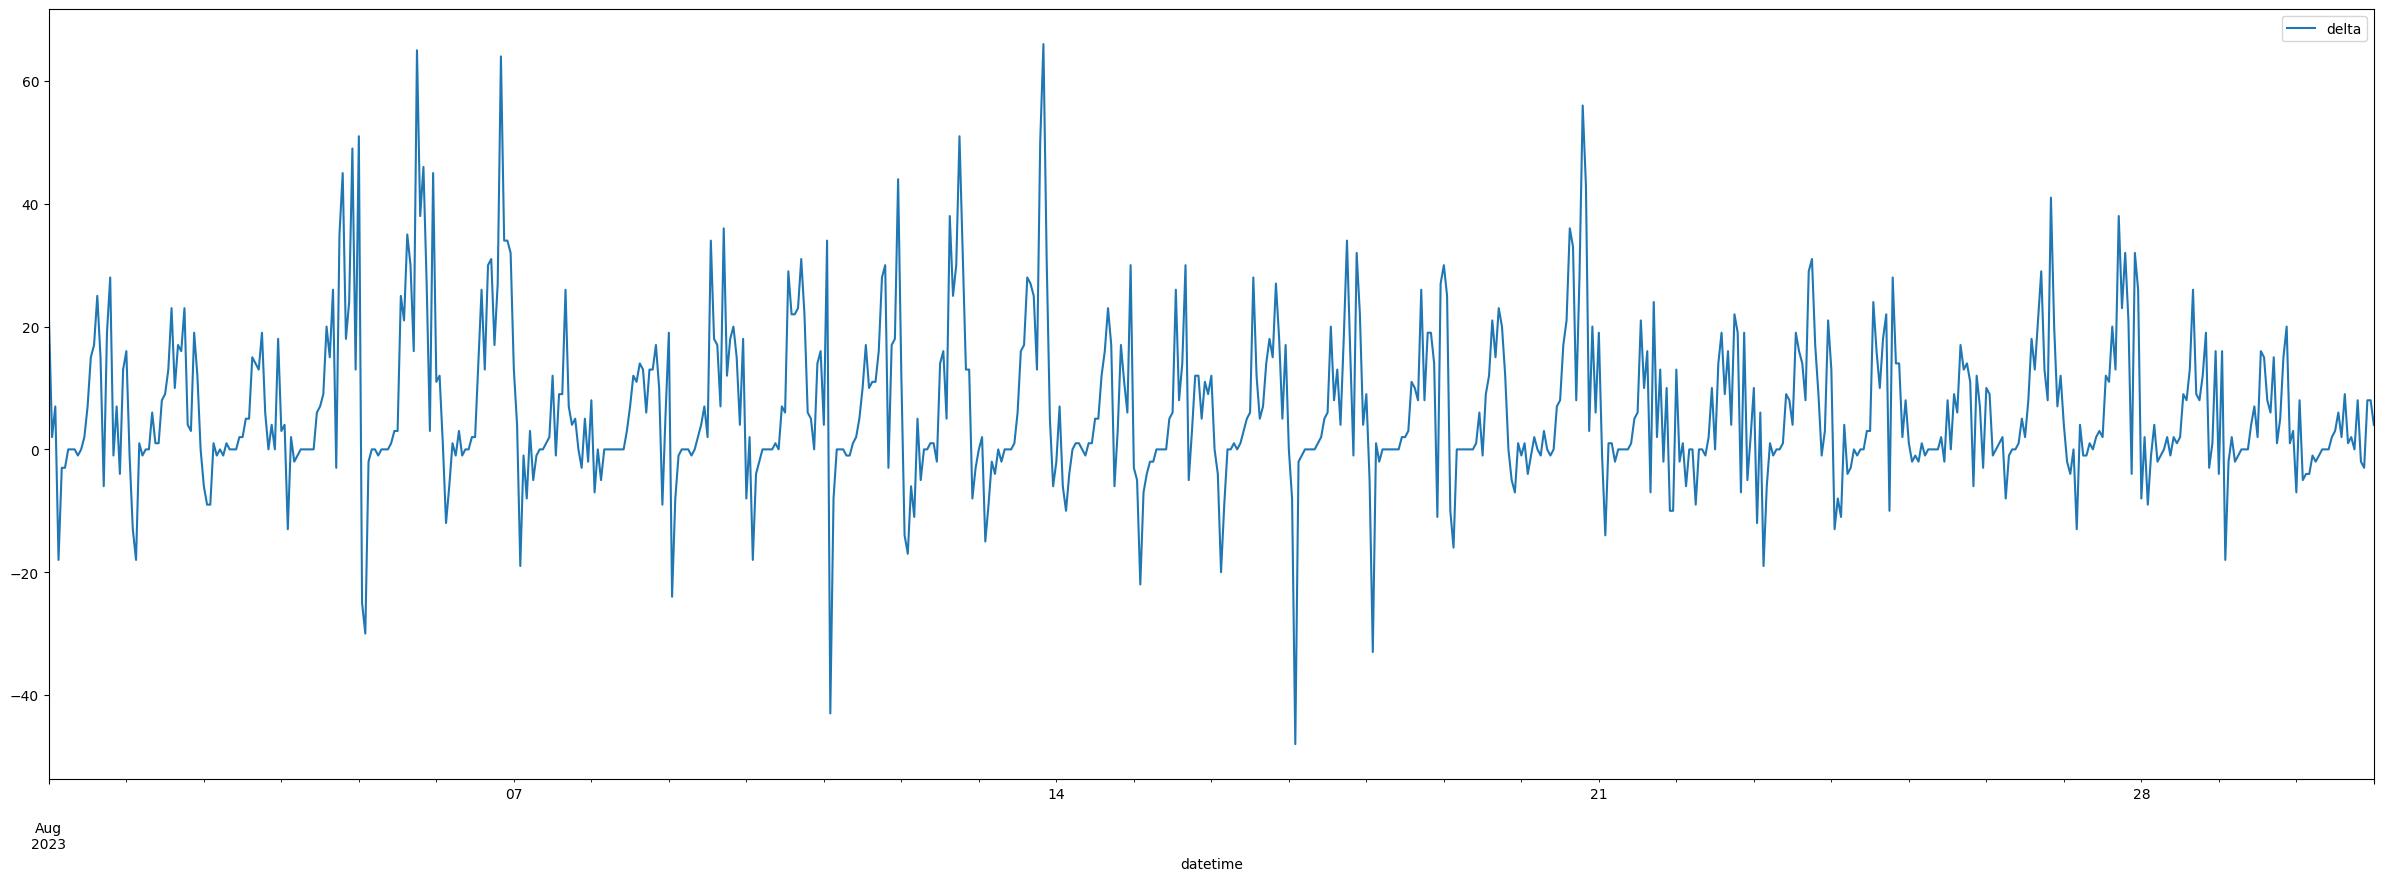

In [131]:
(
    availability_per_station[
    (availability_per_station['station_name'] == 'delacommune_placejacques-cartier') & 
    (availability_per_station['year'] == 2023) &
    (availability_per_station['datetime'].between('2023-08-01', '2023-08-31'))
    ]
    .plot(kind='line', x='datetime', y=['delta'], figsize=(30,10))
)

- We can see that the deltas are consistently positive, which explain the substantial amount observed for the `cum_delta` figures
- The above chart pertains to just one station, but the situation is similar to more stations as observed in the groupby 

### Savior

Thankfully, people around the world are interested in mobility and Max Halford has been scraping station status from around the world every 15 minutes and making the data available as a training dataset. It requires a bit of refactoring, but it's grant us a dataset overtime displaying the amount of bikes available overtime per station. To obtain that dataset, follow this steps:

- clone the repository https://github.com/MaxHalford/bike-sharing-history/tree/main with the command `git clone https://github.com/MaxHalford/bike-sharing-history.git`. It will take a while as it's more than 20 GB.
- Read this blog post to understand more about his project `https://maxhalford.github.io/blog/bike-sharing-forecasting-training-set/`
- Within the local repository, create a new script under ./scripts/<name_of_the_file>.py
- The script content is displayed below on the next cell . (It's commented out to avoid errors)

In [3]:
'''
import collections
import csv
import datetime as dt
import json
import os
import pathlib
import re

import git

def jcdecaux_scrub(geojson):
    for station in geojson["features"]:
        yield {
            "station": station["properties"]["name"],
            "longitude": station["geometry"]["coordinates"][0],
            "latitude": station["geometry"]["coordinates"][1],
            "bikes": station["properties"]["available_bikes"],
            "stands": station["properties"]["available_bike_stands"],
        }


def gbfs_scrub(geojson):
    for station in geojson["features"]:
        yield {
            "station": station["properties"]["name"],
            "longitude": station["geometry"]["coordinates"][0],
            "latitude": station["geometry"]["coordinates"][1],
            "bikes": station["properties"]["num_bikes_available"],
            "stands": station["properties"]["num_docks_available"],
        }

# List the existing (city, provider) pairs
systems = [("montreal","bixi")]

# We're going to loop over all the commits since the start of time. It's ok to do this, because
# most commits will be skipped. Indeed, we can skip all commits which pertain to a month which
# has already been archived.
# We do however limit ourselves to the latest full month, because we don't want to archive partial
# months.
end_of_last_month = dt.datetime.now(dt.timezone.utc).replace(
    day=1, hour=23, minute=59, second=59
) - dt.timedelta(days=1)
commits = git.Repo(".").iter_commits("--all", reverse=True, until=end_of_last_month)
archive_dir = pathlib.Path("archive")

# We keep track of the latest update for each station, so that we can skip updates which don't
# change anything. We also keep track of the number of skipped updates, so that we can record
# this information in the CSV file.
latest_update_by_station = collections.defaultdict()
skipped_updates_by_station = collections.defaultdict(int)

for i, commit in enumerate(commits):
    commit_at = commit.committed_datetime.astimezone(dt.timezone.utc)
    year = commit_at.strftime("%Y")
    month = commit_at.strftime("%h")

    if i % 1_000 == 0:
        print(f"Processing commit {i} ({commit_at.isoformat()})")

    # This loop is responsible for archiving the bike station updates. The next loop will archive
    # the weather updates.
    for city, provider in systems:
        # Skip if the data has already been stored
        # if ("bike-sharing", city, provider, str(year), month) in existing_parquet_keys:
        #     continue

        try:
            blob = commit.tree / "data" / "stations" / city / f"{provider}.geojson"
        except KeyError:
            continue

        # The data has been scrapped and stored as is. This is where we normalize it to a single
        # format.
        scrub = {
            "jcdecaux": jcdecaux_scrub,
        }.get(provider, gbfs_scrub)

        # We store the data in a CSV file per month
        csv_file = archive_dir / "stations" / city / provider / year / f"{month}.csv"
        csv_file.parent.mkdir(parents=True, exist_ok=True)

        with open(csv_file, "a") as f:
            writer = csv.DictWriter(
                f,
                fieldnames=[
                    "station",
                    "longitude",
                    "latitude",
                    "commit_at",
                    "skipped_updates",
                    "bikes",
                    "stands",
                ],
            )

            # Write the header if the file is empty
            if csv_file.stat().st_size == 0:
                writer.writeheader()

            for update in scrub(geojson=json.load(blob.data_stream)):
                station_key = (city, provider, update["station"])

                # We don't write anything if the data hasn't changed
                if (
                    (latest_update := latest_update_by_station.get(station_key))
                    and latest_update["bikes"] == update["bikes"]
                    and latest_update["stands"] == update["stands"]
                ):
                    skipped_updates_by_station[station_key] += 1
                    continue

                update["commit_at"] = commit_at.isoformat()
                update["skipped_updates"] = skipped_updates_by_station[station_key]
                writer.writerow(update)
                latest_update_by_station[station_key] = update
                skipped_updates_by_station[station_key] = 0
'''

'\nimport collections\nimport csv\nimport datetime as dt\nimport json\nimport os\nimport pathlib\nimport re\n\nimport git\n\ndef jcdecaux_scrub(geojson):\n    for station in geojson["features"]:\n        yield {\n            "station": station["properties"]["name"],\n            "longitude": station["geometry"]["coordinates"][0],\n            "latitude": station["geometry"]["coordinates"][1],\n            "bikes": station["properties"]["available_bikes"],\n            "stands": station["properties"]["available_bike_stands"],\n        }\n\n\ndef gbfs_scrub(geojson):\n    for station in geojson["features"]:\n        yield {\n            "station": station["properties"]["name"],\n            "longitude": station["geometry"]["coordinates"][0],\n            "latitude": station["geometry"]["coordinates"][1],\n            "bikes": station["properties"]["num_bikes_available"],\n            "stands": station["properties"]["num_docks_available"],\n        }\n\n# List the existing (city, provider

Using the dataset extracted, we can now proceed with the analysis

In [17]:
# concatanaing all data raw data, derived from the script above, into a single dataframe 
# as the raw data is stored in several files with format year/month
files_list = []
for root, dirs, files in os.walk("raw_data/"):
    for file in files:
        if file.endswith(".csv"):
             files_list.append(os.path.join(root, file))

df = concat(list(map(lambda x: read_csv(x), files_list)))
df['commit_at'] = to_datetime(df['commit_at'])

In [20]:
df

,station,longitude,latitude,commit_at,skipped_updates,bikes,stands
0,Métro Champ-de-Mars (Viger / Sanguinet),-73.556777,45.510253,2024-04-06 08:34:21+00:00,0,9,26
1,de Grosbois / Duchesneau,-73.531242,45.611231,2024-04-06 08:34:21+00:00,0,0,11
2,Fullum / Ste-Catherine,-73.548044,45.527138,2024-04-06 08:34:21+00:00,0,0,9
3,Montcalm / de Maisonneuve,-73.557890,45.519132,2024-04-06 08:34:21+00:00,0,8,5
4,Alexandre-DeSève / Ste-Catherine,-73.553789,45.521188,2024-04-06 08:34:21+00:00,0,0,4
...,...,...,...,...,...,...,...
95824,St-Antoine / Jean-Paul Riopelle,-73.560590,45.503048,2025-01-31 23:49:15+00:00,1,13,8
95825,Parc Jeanne-Mance (du Mont-Royal / du Parc),-73.589117,45.516929,2025-01-31 23:49:15+00:00,1,14,19
95826,Place Valois (Valois / Ontario),-73.543126,45.547018,2025-01-31 23:49:15+00:00,0,11,10
95827,Wellington / Queen,-73.555344,45.497704,2025-01-31 23:49:15+00:00,1,14,7


In [ ]:
# resampling data to every 15 minutes for analysis
history = (
    df
    .groupby('station')
    .resample(
        rule='15min',
        on='commit_at'
    ).max()
    .drop(columns='station')
    .groupby('station').shift(1)
    .groupby('station').ffill()
    .dropna(subset=['skipped_updates'])
    [['bikes', 'stands']].astype('uint8')
)

## Explore weather data

In [ ]:
del cleaned_hist_rides